In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import scipy as sp
import scipy.sparse
from scipy.special import erf
from IPython.display import clear_output
import copy
import matplotlib.animation as animation
from IPython.display import HTML
from progress import Progress

In [16]:
width = 20
height = 21
p = 0.3
#max_delta = 0.5

In [17]:
N = width * height - height // 2 
r0 = np.zeros((N, 2))
tmp = 0
for i in range(height):
    for j in range(width - i % 2):
        r0[tmp, 0] = j + (1 / 2) * (i % 2)
        r0[tmp, 1] = i * np.sqrt(3) / 2
        tmp += 1
r0 -= r0.mean(0)
down = slice(width)
up = slice(-width - 1 + (height % 2), None)

In [18]:
np.random.seed(0)
I, J = [], [] # i-ые элементы в массивах соединены
tmp = 0
for i in range(height):
    for j in range(width - i % 2 - 1):
        if np.random.rand() < p:
            I.append(tmp)
            J.append(tmp + 1)
        tmp += 1
    tmp += 1
tmp = 0
for i in range(0, height, 2):
    for j in range(width - i % 2 - 1):
        if i != height - 1:
            if np.random.rand() < p:
                I.append(tmp)
                J.append(tmp + width)
            if np.random.rand() < p:
                I.append(tmp + width)
                J.append(tmp + 1)
        if i != 0:
            if np.random.rand() < p:
                I.append(tmp)
                J.append(tmp - width + 1)
            if np.random.rand() < p:
                I.append(tmp - width + 1)
                J.append(tmp + 1)
        tmp += 1
    tmp += width
I = np.array(I)
J = np.array(J)
K = len(I)
A = sp.sparse.csr_matrix((np.ones(K), (I, J)), (N, N))

In [14]:
sp.sparse.csgraph.connected_components(A)


(1,
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]))

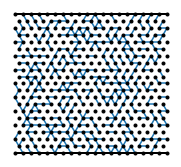

In [19]:
plt.figure(figsize=(3, 3))
plt.plot(r0[:,0], r0[:,1], 'k.')
lines = np.zeros((K, 2, 2))
lines[:,0] = r0[I]
lines[:,1] = r0[J]
lc = LineCollection(lines)
plt.plot(r0[up, 0], r0[up, 1], 'k', lw=2)
plt.plot(r0[down, 0], r0[down, 1], 'k', lw=2)
plt.gca().add_collection(lc)
plt.gca().set_aspect('equal')
plt.axis('off')
fig = plt.gcf()

In [20]:
lengths = np.sqrt(np.sum((r0[I] - r0[J])**2, 1)) # pos_new - под действием силы, pos - начальное

In [21]:
B = sp.sparse.csr_matrix((np.ones(K), (I, np.arange(K))), (N, K)) # B - 
B -= sp.sparse.csr_matrix((np.ones(K), (J, np.arange(K))), (N, K))


def forces(r): 
    r_ij = B.T@r # разница между двумя связанными вершинами по Х и Y
    lengths_new = np.sqrt(np.sum(r_ij**2, 1))
    tension = lengths_new - lengths # при k = 1 также является модулем силы упругости
    F = -B@(r_ij.T / lengths_new * tension).T
    return F  # для единичных масс

    
def energy(r, v):
    r_ij = B.T@r
    lengths_new = np.sqrt(np.sum(r_ij**2, 1))
    pot_en = np.sum((lengths_new - lengths) ** 2 / 2) # при k = 1 также является модулем силы упругости
    kin_en = np.sum(v ** 2 / 2)
    return pot_en + kin_en

In [22]:
%%time
strain_rate = 0.0001 # скорость деформации системы
max_strain = 0.5
max_t = max_strain/strain_rate
tau = 0.1 * max_t
t0 = -5 * tau
dt = 0.1
substeps = 100
steps = int(max_t / dt / substeps - t0 / dt / substeps)
dv = np.array((0, (height - 1) * np.sqrt(3) / 2 * strain_rate / 2 / substeps / 100))
r = r0.copy() # r0 - начальные координаты частиц, r - новые
en = np.zeros(steps)
F = forces(r)
r_new = r + F * dt ** 2 /2 # r = x(t), r_new = x(t + dt)
strain, stress, time = np.zeros((3, steps)) 
plot_data = np.zeros((steps, N, 2))


def strain_function(t):
    return strain_rate/2*(t + np.exp(-t**2/2/tau**2)*tau*np.sqrt(2/np.pi) + t*erf(t/np.sqrt(2)/tau))

t = t0 
for i in Progress(range(steps)): 
    for j in range(substeps):
        r_prev = r
        r = r_new
        F = forces(r)        
        r_new = 2 * r - r_prev + F * (dt ** 2)
        t += dt
        current_strain = strain_function(t)
        r_new[up, 1] = r0[up, 1] * (1 + current_strain)
        r_new[down, 1] = r0[down, 1] * (1 + current_strain)
        r_new[up, 0] = r0[up, 0]
        r_new[down, 0] = r0[down, 0]
    plot_data[i] = r
    stress[i] = (F[down, 1].sum() - F[up, 1].sum()) / width / 2
    strain[i] = current_strain
    time[i] = t

HTML(value='')

Wall time: 26.1 s


In [ ]:
# построить новые графики для разных p

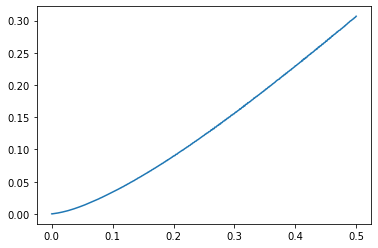

In [13]:
plt.plot(strain, stress)

In [23]:
fig = plt.figure(figsize=(15, 15))
plt.gca().set_aspect('equal')
points, = plt.plot(plot_data[0,:,0], plot_data[0,:,1], 'k.')
lines = np.zeros((K, 2, 2))
lc = LineCollection(lines)
plt.gca().add_artist(lc)
plt.xlim(-1 - width / 2, 1 + width / 2)
plt.ylim(-10 - height * np.sqrt(3) / 4, 10 + height * np.sqrt(3) / 4)

def update(i):
    lines = np.zeros((K, 2, 2))
    lines[:,0] = plot_data[i][I]
    lines[:,1] = plot_data[i][J]
    lc.set_segments(lines)
    points.set_data(plot_data[i,:,0], plot_data[i,:,1])
    return lc, points

ani = animation.FuncAnimation(fig, update, np.arange(steps), interval=50, blit=True)
plt.close()
HTML(ani.to_html5_video())

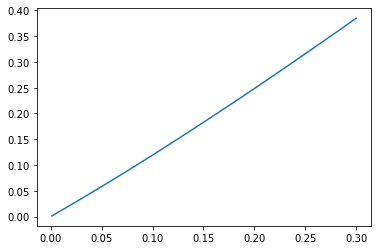

In [25]:
plt.plot(strain, stress)

# массивы с промежуточными значениями сил, действующих на нижние (верхние) частицы

In [22]:
np.savetxt('strain_' + str(p)  + '.dat', np.column_stack((strain, stress))) # график напряжения от деформации в зависимости от p (когда напряжение возникает сразу после приложения силы и когда система рааспадается на куски и напряжение почти не возникает)

(0.0, 0.5)

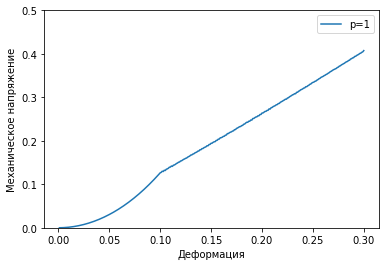

In [25]:
strain_stress = np.loadtxt(f'strain_{p:g}.dat')
plt.plot(strain_stress[:, 0], strain_stress[:, 1], label=f'p={p:g}')
plt.legend()
plt.xlabel('Деформация')
plt.ylabel('Механическое напряжение')
plt.ylim(0, 0.5) 

(0.0, 0.01)

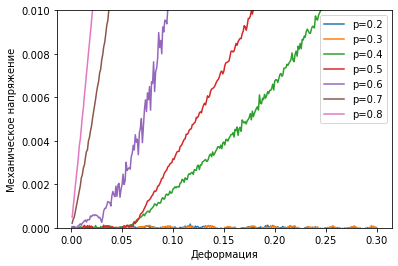

In [12]:
for p in np.arange(0.2, 0.9, 0.1):
    strain_stress = np.loadtxt(f'strain_{p:g}.dat')
    plt.plot(strain_stress[:, 0], strain_stress[:, 1], label=f'p={p:g}')
plt.legend()
plt.xlabel('Деформация')
plt.ylabel('Механическое напряжение')
plt.ylim(0, 0.01)